# OR 568 - Rogers Rangers
## NYC Rolling Sales Dataset

James Baker

Arturo Davila-Andino

Gridihar Kaushik Ramachandran (GK)

Andrew So

## Developer Notes

*James B*: For tables, I generally build them in excel and then convert them into Markdown tables at these two links:
* https://tableconvert.com/
* https://www.tablesgenerator.com/markdown_tables

# Initial Setup / Package Imports

In [1]:
# ipak function: install and load multiple R packages.
# check to see if packages are installed. Install them if they are not, then load them into the R session.
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

# usage
packages <- c(
  "ggplot2", 
  "plyr", 
  "mlbench", 
  "e1071", 
  "dplyr", 
  "caret", #  Contains functions to streamline the model training process for complex regression and classification problems
  "pls", # For Partial Least Squares 
  "lars", # For Penalized Models
  "elasticnet", # For Penalized Models
  "AppliedPredictiveModeling",
  "tidyr",
  "magrittr",
  "stringr",
  "readr",
  "nortest",
  "epiDisplay",
  "corrplot",
  "RColorBrewer", 
  "bestNormalize"
)
ipak(packages)

Loading required package: ggplot2

Loading required package: plyr

Loading required package: mlbench

Loading required package: e1071

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: caret

Loading required package: lattice

Loading required package: pls


Attaching package: 'pls'


The following object is masked from 'package:caret':

    R2


The following object is masked from 'package:stats':

    loadings


Loading required package: lars

Loaded lars 1.2


Loading required package: elasticnet

Loading required package: AppliedPredictiveModeling

Loading required package: tidyr

Loading required package: magrittr


Attaching package: 'mag

ggplot2                      plyr                   mlbench 
                     TRUE                      TRUE                      TRUE 
                    e1071                     dplyr                     caret 
                     TRUE                      TRUE                      TRUE 
                      pls                      lars                elasticnet 
                     TRUE                      TRUE                      TRUE 
AppliedPredictiveModeling                     tidyr                  magrittr 
                     TRUE                      TRUE                      TRUE 
                  stringr                     readr                   nortest 
                     TRUE                      TRUE                      TRUE 
               epiDisplay                  corrplot              RColorBrewer 
                     TRUE                      TRUE                      TRUE 
            bestNormalize 
                     TRUE

## Dataset Import
Dataset found at: https://www.kaggle.com/new-york-city/nyc-property-sales#


We use a a try-catch block in an attempt to find the NYC Rolling Sales data locally; if it doesn't exist, then read it from the hardcoded Google Drive link.

**Note** We used a variety of both manual and automated methods to massage the data before it hits the R pipeline:

* We used a web-facing API called [Geocod.io](https://www.geocod.io/) to add associated latitude/longitudal data for potential use in the model.

* In addition, we used a PowerShell Script `Process-Address.ps1` in an attempt to strip house numbers from the address in an attempt to categorize records by street name (e.g., properties on Broadway, 5th Avenue, 1st Street, etc.)

**These changes resulted in our using a new dataset called `nyc-rolling-sales-latlong-streets.csv`, which the project will attempt to source locally (if it exists) or via an open endpoint on the Team's Google Drive.**

In [2]:
# The filepath on Google Drive.
drive.fileID <- "1E8NdpOww8IKdN1Kw0NcDPQxycU__hsVu" 
drive.filePath <- sprintf("https://drive.google.com/uc?id=%s",drive.fileID)
file.name <- "nyc-rolling-sales-latlong-streets.csv"

# This is a try-catch block in an attempt to find the NYC Rolling Sales data
# locally; if it doesn't exist, then read it from the hardcoded Google Drive link.
nyc.data <- tryCatch(
    # Try
    {
      message(sprintf("Attempting to read `%s` locally...",file.name))
      read.csv(file.name)
    },
    # Catch
    error = function(cond) {
      message(sprintf("Will use Google Drive Version instead at %s...", drive.filePath))
      return( read.csv(drive.filePath) )
    },
    # Finally
    finally = function(cond) {
      return(message("Unknown error occured!"))
    }
)

cat("Number of Rows: ",nrow(nyc.data), "\nNumber of Cols: ", ncol(nyc.data),"\nShowing first 2 rows...")
head(nyc.data, 2)

Attempting to read `nyc-rolling-sales-latlong-streets.csv` locally...



Number of Rows:  84548 
Number of Cols:  25 
Showing first 2 rows...

,NUM,BOROUGH,NEIGHBORHOOD,BUILDING.CLASS.CATEGORY,TAX.CLASS.AT.PRESENT,BLOCK,LOT,EASE.MENT,BUILDING.CLASS.AT.PRESENT,ADDRESS,...,RESIDENTIAL.UNITS,COMMERCIAL.UNITS,TOTAL.UNITS,LAND.SQUARE.FEET,GROSS.SQUARE.FEET,YEAR.BUILT,TAX.CLASS.AT.TIME.OF.SALE,BUILDING.CLASS.AT.TIME.OF.SALE,SALE.PRICE,SALE.DATE
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<chr>,<chr>,...,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,NA,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,7/19/2017 0:00
2,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,NA,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,12/14/2016 0:00


## Data Dictionary

https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf

*James B.:* I used PowerShell to extract/sort the column names; and then I folded a few of them together.

| Column   Name                                                       | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
|---------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `ADDRESS`                                                           |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `APARTMENT   NUMBER`                                                |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `BLOCK`                                                             | The block number (up to 5   digits)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| `BOROUGH`                                                           | A digit code for the borough the   property is located in.      <br>      In order, these are:      <br>(1) Manhattan,      <br>(2) Bronx,       <br>(3) Brooklyn,       <br>(4) Queens, and       <br>(5) Staten Island.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| `BUILDING   CLASS`<br>      (`AT PRESENT` and<br>`AT TIME OF SALE`) | Refer to code here: <br>   https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `BUILDING   CLASS CATEGORY`                                         | Refer to code here: <br>   https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `COMMERCIAL   UNITS`                                                |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `EASE-MENT`                                                         | NO DATA ENTERED                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `GROSS   SQUARE FEET`                                               |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `H1`                                                                |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `LAND   SQUARE FEET`                                                |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `LOT`                                                               | The lot number (up to 4 digits)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `NEIGHBORHOOD`                                                      |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `RESIDENTIAL   UNITS`                                               | The number of houses/apartments   intended for use as a place of residence at the address.      <br> (https://www.lawinsider.com/dictionary/residential-unit)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| `SALE   DATE`                                                       |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `SALE   PRICE`                                                      |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `TAX   CLASS`<br>(`AT PRESENT` and<br>`AT SALE`)                    | Property in NYC is divided into   4 classes:      <br>      Class 1: Most residential property of up to three units<br>(family   homes and small stores or offices with one or two apartments attached),   <br>and most condominiums that are not more than three stories.      <br><br>      Class 2: All other property that is not in Class 1 and is primarily   residential<br>(rentals, cooperatives and condominiums). Class 2   includes:      <br>   • Sub-Class 2a  (4 -    6 unit rental building);      <br>   • Sub-Class 2b  (7 - 10 unit rental building);      <br>   • Sub-Class 2c  (2 - 10 unit cooperative or condominium);   and      <br>   • Class 2  (11 units or more).      <br><br>      Class 3: Most utility property.      <br><br>      Class 4: All commercial and industrial properties, such as office,   retail,<br> factory buildings and all other properties not included in   tax classes 1, 2 or 3.      <br><br>      SOURCE:   https://www1.nyc.gov/site/finance/taxes/definitions-of-property-assessment-terms.page |
| `TOTAL   UNITS`                                                     |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `YEAR   BUILT`                                                      | The 5-digit zip code of the   address                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| `ZIP   CODE`                                                        |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |

# Data Processing

## Initial Exploration

First, we examine the head of the data to get an idea of the structure.

In [3]:
# First, we examine the head of the data to get an idea of the structure.
head(nyc.data,2)

# Make all columns lowercase for consistency's sake
colnames(nyc.data) %<>% str_replace_all("\\s", "_") %>% tolower()

,NUM,BOROUGH,NEIGHBORHOOD,BUILDING.CLASS.CATEGORY,TAX.CLASS.AT.PRESENT,BLOCK,LOT,EASE.MENT,BUILDING.CLASS.AT.PRESENT,ADDRESS,...,RESIDENTIAL.UNITS,COMMERCIAL.UNITS,TOTAL.UNITS,LAND.SQUARE.FEET,GROSS.SQUARE.FEET,YEAR.BUILT,TAX.CLASS.AT.TIME.OF.SALE,BUILDING.CLASS.AT.TIME.OF.SALE,SALE.PRICE,SALE.DATE
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<chr>,<chr>,...,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,NA,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,7/19/2017 0:00
2,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,NA,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,12/14/2016 0:00


To further supplement information gathering, we observe how many predictors there are.

In [4]:
# Helper function to pretty print column names for a dataframe
prettyPrintCols <- function(data.frame) {
     print(colnames(data.frame) %<>% str_replace_all("\\s", "_") %>% tolower())
}

In [5]:
# To further supplement information gathering, we observe how many predictors there are.
sprintf("There are %s cols in nyc.data:", ncol(nyc.data))
prettyPrintCols(nyc.data)

[1] "There are 25 cols in nyc.data:"

 [1] "num"                            "borough"                       
 [3] "neighborhood"                   "building.class.category"       
 [5] "tax.class.at.present"           "block"                         
 [7] "lot"                            "ease.ment"                     
 [9] "building.class.at.present"      "address"                       
[11] "street"                         "latitude"                      
[13] "longitude"                      "apartment.number"              
[15] "zip.code"                       "residential.units"             
[17] "commercial.units"               "total.units"                   
[19] "land.square.feet"               "gross.square.feet"             
[21] "year.built"                     "tax.class.at.time.of.sale"     
[23] "building.class.at.time.of.sale" "sale.price"                    
[25] "sale.date"                     


Then, we observe the current structure:

In [6]:
str(nyc.data)

'data.frame':	84548 obs. of  25 variables:
 $ num                           : int  4 5 6 7 8 9 10 11 12 13 ...
 $ borough                       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ neighborhood                  : chr  "ALPHABET CITY" "ALPHABET CITY" "ALPHABET CITY" "ALPHABET CITY" ...
 $ building.class.category       : chr  "07 RENTALS - WALKUP APARTMENTS             " "07 RENTALS - WALKUP APARTMENTS             " "07 RENTALS - WALKUP APARTMENTS             " "07 RENTALS - WALKUP APARTMENTS             " ...
 $ tax.class.at.present          : chr  "2A" "2" "2" "2B" ...
 $ block                         : int  392 399 399 402 404 405 406 407 379 387 ...
 $ lot                           : int  6 26 39 21 55 16 32 18 34 153 ...
 $ ease.ment                     : logi  NA NA NA NA NA NA ...
 $ building.class.at.present     : chr  "C2" "C7" "C7" "C4" ...
 $ address                       : chr  "153 AVENUE B" "234 EAST 4TH   STREET" "197 EAST 3RD   STREET" "154 EAST 7TH STREET" ...
 $ street    

Based on manual observation and what we see in the data here, we observe the following:

* `ease.ment` is 100% null.
* `land.square.feet`, `gross.square.feet`, and `sale.price` are chars when they should be numeric vectors.

So, we will clean the data in the next section.

## Data Cleaning/Transformations in R

### Deep Copy

To begin, we will no longer use `nyc.data` as the dataset for processing in R; we will use a copy to work over and retain the original.

In [7]:
# Begin with creating a deep copy of the nyc.data Dataframe for use onwards.

df <- nyc.data

#TODO: Be sure to split Y from the data BEFORE we boxcox/preprocess.
# df <- subset(nyc.data, select = -c(sale.price))
# df.y <- nyc.data$sale.price

# Maintain an internal switch to use the STREET and LATLONG predictors.
useStreet <- TRUE
useLatLongs <- FALSE

### Nulling unused predictors

`ease.ment`, `apartment.number`, `sale.date` will not be used in the model because they either 

* Do not fit the purpose of the model, or
* Do not have data that can contribute to the model.

This will also NULL out any other predictors that will not be used in the model.

In [8]:
# ### Nulling unused predictors
# `ease.ment`, `apartment.number`, `sale.date` will not be used in the model because they either 
# * Do not fit the purpose of the model, or
# * Do not have data that can contribute to the model.
# This will also NULL out any other predictors" that will not be used in the model.

df$ease.ment <- NULL
df$apartment.number <- NULL
df$sale.date <- NULL

# This is a control function to allow usage of the STREET and
# LATLONG predictors within the data set.
if (!useStreet) {
    print("UseStreet is DISABLED.")
    df$street <- NULL
}

if (!useLatLongs) {
    print("UseLATLONGS is DISABLED.")
    df$latitude <- NULL
    df$longitude <- NULL
}
prettyPrintCols(df)

[1] "UseLATLONGS is DISABLED."
 [1] "num"                            "borough"                       
 [3] "neighborhood"                   "building.class.category"       
 [5] "tax.class.at.present"           "block"                         
 [7] "lot"                            "building.class.at.present"     
 [9] "address"                        "street"                        
[11] "zip.code"                       "residential.units"             
[13] "commercial.units"               "total.units"                   
[15] "land.square.feet"               "gross.square.feet"             
[17] "year.built"                     "tax.class.at.time.of.sale"     
[19] "building.class.at.time.of.sale" "sale.price"                    


### Recasting predictors

#### Numerics
`sale.price`, `land.square.feet`, and `gross.square.feet` were identified to have been malformed, so they will be re-cast as numeric vectors.

##### Price and Square Footage

In [9]:
# #### Numerics
# `sale.price`, `land.square.feet`, and `gross.square.feet` were identified to have been malformed, 
# so they will be re-cast as numeric vectors.

##### Price and Square Footage
df$sale.price <- as.numeric(as.character(df$sale.price))
df$land.square.feet <- as.numeric(as.character(df$land.square.feet))
df$gross.square.feet <- as.numeric(as.character(df$gross.square.feet))

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


#### Factors
The following predictors can be factorized (made into categories):

In [10]:
# #### Factors
# The following predictors can be factorized (made into categories):
df$borough <- as.factor(df$borough)
df$neighborhood <- as.factor(df$neighborhood)
df$building.class.category <- as.factor(df$building.class.category)

# PRESENT CATEGORIES
df$tax.class.at.present <- as.factor(df$tax.class.at.present)
df$building.class.at.present <- as.factor(df$building.class.at.present)

# TIME OF SALE
df$tax.class.at.time.of.sale <- as.factor(df$tax.class.at.time.of.sale)
df$building.class.at.time.of.sale <- as.factor(df$building.class.at.time.of.sale) 

# ZIP CODE
df$zip.code <- as.factor(df$zip.code)

# Logic to use Street; if so, then remove the Address since it has no 
# utility here.
if (useStreet) {
    df$street <- as.factor(df$street)
    df$address <- NULL
}

#### Factorizing building age

There are a few options that we can do here with respect to the building's age:
We can:
1. Convert to `age` by subtracting from 2017
2. Convert to intervals
3. Convert to factor and leave as is

**The team chooses option 3.**

In [11]:
#doing option 3
df$year.built <- as.factor(df$year.built)
# df$sale.price = as.numeric(df$sale.price) # ??? This seems redundant

#### Data Filtering

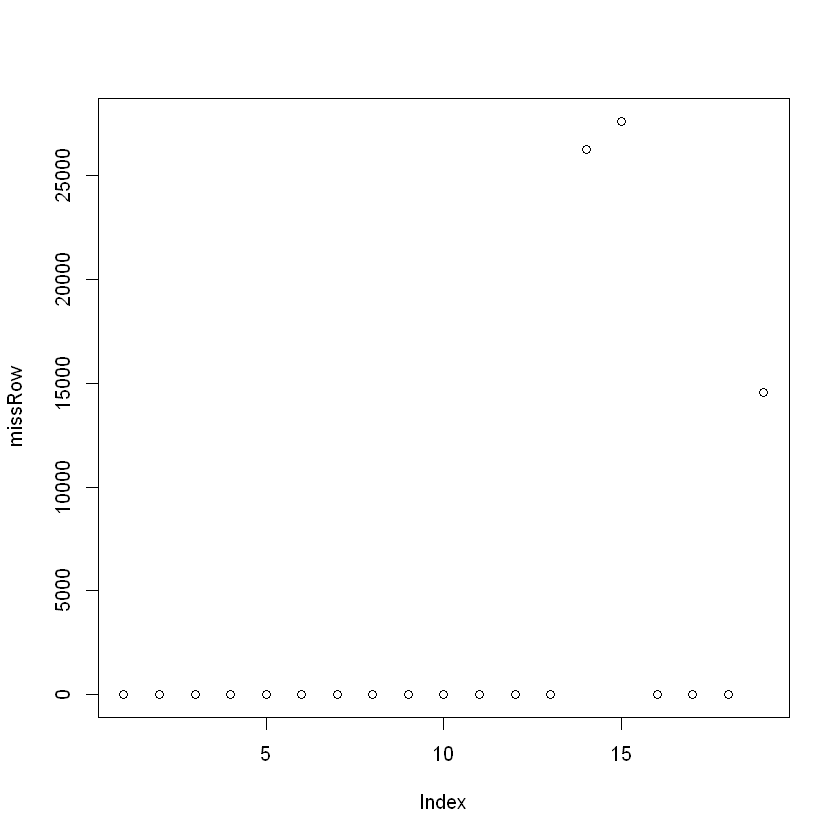

In [12]:
missRow <- colSums(is.na(df))
plot(missRow)

##### Before Dropping Nulls

We apply a filter to the dataset to do the following:
* Remove observations with incomplete results (lack of dimensions + sale price)

##### Applying filters
The following filters are applied to the dataset:
* Eliminate incomplete observations by dropping records with NULL values in square footage and sale price.
* Reining in gross and land square feet to properties > 100 square feet.
 * This is done to remove records that are either too dirty or have no significant contribution with respect to real estate
* Using only sale prices greater than \\$100,000
 * This is done because price per square foot *realistically* would be (extremely optimistically) $1000/sq. ft in NYC; a minimum

In [13]:
# drop NA's that were created during the conversion from the "-" value
df <- df %>% drop_na(c(gross.square.feet,land.square.feet, sale.price))

# removing datapoints whose sqftage is less than 100
# removing datapoints whose sale price is <100k. Since median price @nyc is around 1.8k
df <- df %>% filter(land.square.feet>100) 
df <- df %>% filter(gross.square.feet >100)
df <- df %>% filter(sale.price>100000)

In [14]:
freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

# TODO: Add additional filters here? As it is, data is heavily skewed towards commercial properties

new_freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
new_freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
new_freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [15]:
# df <- nyc.data
# df$sale.price <- as.numeric(as.character(df$sale.price))
# df$land.square.feet <- as.numeric(as.character(df$land.square.feet))
# df$gross.square.feet <- as.numeric(as.character(df$gross.square.feet))

# df$ease.ment = NULL
# df$apartment.number = NULL
# df$sale.date = NULL

# df$borough = as.factor(df$borough)
# df$neighborhood = as.factor(df$neighborhood)
# df$building.class.category = as.factor(df$building.class.category)
# df$tax.class.at.present = as.factor(df$tax.class.at.present )

#block and lot

# df$building.class.at.present = as.factor(df$building.class.at.present)

#address needs to be feature engineered
# avenue, broadway etc.

# df$zip.code = as.factor(df$zip.code)

#total units is a calculated field. can be ignored

#convert sqftage to numeric
# df$land.square.feet = as.numeric(df$land.square.feet)
# df$gross.square.feet = as.numeric(df$gross.square.feet)

#need to feature engineer year built- 
# option 1- convert to 'age' by subtracting from 2017
# option 2- convert to intervals
# option 3- convert to factor and leave as is

#doing option 3
# df$year.built <- as.factor(df$year.built)

# df$tax.class.at.time.of.sale = as.factor(df$tax.class.at.time.of.sale)
# df$building.class.at.time.of.sale = as.factor(df$building.class.at.time.of.sale)

# df$sale.price = as.numeric(df$sale.price) 

# removed NA and keep only distinct records
# df <- df %>% distinct() %>% drop_na(c(gross.square.feet,land.square.feet, sale.price))

# #drop NA's that were created during the conversion from the "-" value
# df <- df %>% drop_na(c(gross.square.feet,land.square.feet, sale.price))

# freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
# freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
# freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

# removing datapoints whose sqftage is less than 100
# removing datapoints whose sale price is <100k. Since median price @nyc is around 1.8k

# df <- df %>% filter(land.square.feet>100) 
# df <- df %>% filter(gross.square.feet >100)
# df <- df %>% filter(sale.price>100000)

# TODO: Add additional filters here? As it is, data is heavily skewed towards commercial properties

# new_freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
# new_freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
# new_freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

## Descriptive Stats for Price and Square Footage

In [16]:
# Descriptive Stats
print("For `sale.price`...")
max(df$sale.price)
class(df$sale.price)
max(df$sale.price)
min(df$sale.price)

cat("\n")
print("For `gross.square.feet`...")
max(df$gross.square.feet)
min(df$gross.square.feet)

cat("\n")
print("For `land.square.feet`...")
max(df$land.square.feet)
min(df$land.square.feet)

[1] "For `sale.price`..."


[1] 2.21e+09

[1] "numeric"

[1] 2.21e+09

[1] 100700


[1] "For `gross.square.feet`..."


[1] 3750565

[1] 120


[1] "For `land.square.feet`..."


[1] 4228300

[1] 200

## Adjusting the data for skewness

To get an idea of the skewness of the data, we will produce a histogram.

We choose `gross.square.feet` arbitrarily.

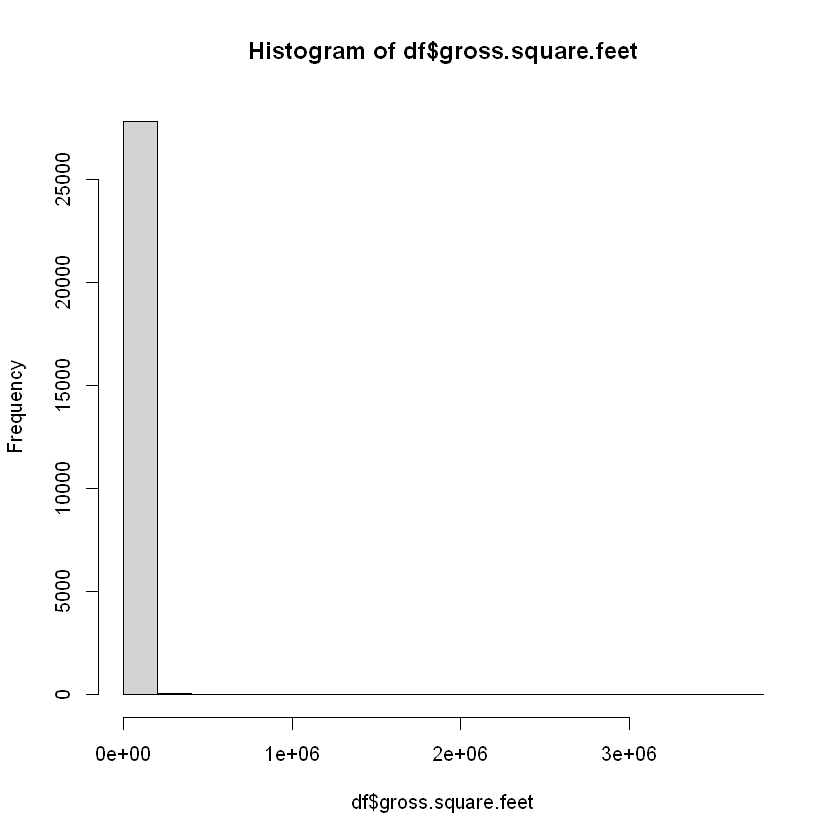

In [17]:
# hist(df$sale.price)
hist(df$gross.square.feet)

Based on the histogram above for gross square feet, we observed that the data was heavily skewed and can benefit from a Box Cox + Center/Scaling transformation for improved model performance.

BEFORE we do that though, we will separate `sale.price` from the dataframe to prevent the same transformation from applying to the response.

In [18]:
# Based on the histogram above for gross square feet, we observed that the data was heavily skewed and can benefit 
# from a Box Cox + Center/Scaling transformation for improved model performance.
# BEFORE we do that though, we will separate `sale.price` from the dataframe to 
# prevent the same transformation from applying to the response.
df.y <- as.data.frame(df$sale.price)
colnames(df.y) <- c("sale.price")

df <- subset(df, select = -c(sale.price))

# Validate that sale.price has been removed from the structure of the main data frame.
prettyPrintCols(df)

 [1] "num"                            "borough"                       
 [3] "neighborhood"                   "building.class.category"       
 [5] "tax.class.at.present"           "block"                         
 [7] "lot"                            "building.class.at.present"     
 [9] "street"                         "zip.code"                      
[11] "residential.units"              "commercial.units"              
[13] "total.units"                    "land.square.feet"              
[15] "gross.square.feet"              "year.built"                    
[17] "tax.class.at.time.of.sale"      "building.class.at.time.of.sale"


### BoxCox/Centering/Scaling

We use the `preProcess()` method to prep a boxcox/centering/scaling routine against the dataset.

In [19]:
# Preload a preprocessing routine
df.preProc <- preProcess(
    df,
    method = c("BoxCox", "center", "scale")
)

In [20]:
## Apply the transformations
df.trans <- predict(df.preProc, df)

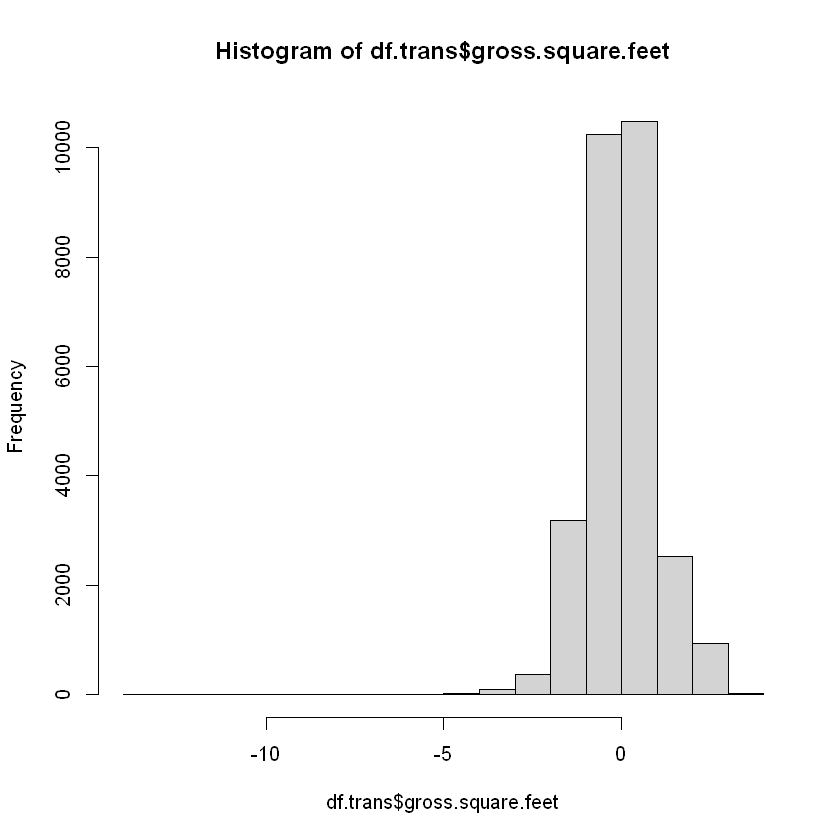

In [21]:
hist(df.trans$gross.square.feet)

## Multicollinearity Test

In [22]:
# # check multicollinearity
# numericpredictors <- c('residential.units','commercial.units','total.units','land.square.feet','gross.square.feet','sale.price')
# df_numpreds <- subset(df, select= numericpredictors)
# corr <- cor(df_numpreds)
# corr
# corrplot(corr,method= "number",col=brewer.pal(n=8, name="PuOr"))

## Data Culling

In [23]:
# #remove total units as a predictor since it is highly correlated to # of residential units and commercial units

# # one hot encoding the categorical variables
# # borough 
# # neighborhood
# # building.class.category 
# # tax.class.at.present 
# # building.class.at.present
# # zip.code
# # year.built
# # tax.class.at.time.of.sale
# # building.class.at.time.of.sale

# dmy <- dummyVars(" ~ borough +
# neighborhood +
# building.class.category +
# tax.class.at.present +
# building.class.at.present +
# zip.code +
# year.built +
# tax.class.at.time.of.sale +
# building.class.at.time.of.sale", data = df)
# trsf <- data.frame(predict(dmy, newdata = df))
# dim(trsf)

# df_for_modeling <- cbind(trsf, df_numpreds)
# dim(df_for_modeling)

# Modeling

## Data Partioning

In [24]:
# #split data into train, validation and test
# inTraining <- createDataPartition(df_for_modeling$sale.price, p = .70, list = FALSE)
# trainset <- df_for_modeling[inTraining,]
# testandvalidation  <- df_for_modeling[-inTraining,]

# testid <- createDataPartition(testandvalidation$sale.price, p = .50, list = FALSE)
# testset <- testandvalidation[testid,]
# validationset <- testandvalidation[-testid,]

# dim(trainset)
# dim(validationset)
# dim(testset)

# # training various models

# #Simple Linear Regression

### Partitioning data for the Partial Least Squares Model


In [25]:
# Set seed
# create a list of random number ranging from 1 to number of rows from actual data 
# and 70% of the data into training data

df.shuffled <- sort(sample(nrow(df.trans), nrow(df.trans)*.7))


# Create both training and test data sets by using the random ordering created 
# in the preceding executed line 
df.pls.train <- as.data.frame(df.trans[df.shuffled,])
df.pls.test <- as.data.frame(df.trans[-df.shuffled,])

df.y.pls.train <- as.data.frame(df.y[df.shuffled,])
df.y.pls.test <- as.data.frame(df.y[-df.shuffled,])

# Rename the columns to `sale.price` since that gets removed in the midst of indexing. 
colnames(df.y.pls.train) <- c("sale.price")
colnames(df.y.pls.test) <- c("sale.price")

### Create control for PLS Model

This is the `trainControl` method used for Partial Least Squares; this model will use Monte Carlo Cross Validation for model resampling.


In [26]:
# create control
pls.ctrl <- trainControl(method = "LGOCV",
                     summaryFunction = defaultSummary,
                     classProbs = TRUE,
                     savePredictions = "final"
            )

### Partial Least Squares

In [27]:
str(df.pls.train)

'data.frame':	19537 obs. of  18 variables:
 $ num                           : num  -2.56 -2.53 -2.52 -2.5 -2.48 ...
 $ borough                       : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ neighborhood                  : Factor w/ 254 levels "AIRPORT LA GUARDIA",..: 2 2 2 2 2 2 2 40 40 40 ...
 $ building.class.category       : Factor w/ 47 levels "01 ONE FAMILY DWELLINGS                    ",..: 7 7 7 7 8 9 15 1 2 3 ...
 $ tax.class.at.present          : Factor w/ 11 levels " ","1","1A","1B",..: 7 8 7 8 6 6 7 2 2 2 ...
 $ block                         : num  -1.87 -1.86 -1.86 -1.86 -1.88 ...
 $ lot                           : num  -1.519 -0.4157 0.4322 -0.0448 1.3333 ...
 $ building.class.at.present     : Factor w/ 167 levels " ","A0","A1",..: 17 19 17 19 35 21 143 10 140 15 ...
 $ street                        : Factor w/ 8077 levels "****** 95TH STREET ",..: 1890 3664 3296 1890 3626 3664 1890 7707 7696 7707 ...
 $ zip.code                      : Factor w/ 

In [ ]:
#Partial Least Squares

numComponents <- 10
plsFit <- train(
    x = df.pls.train, # select features/predictors
    y = df.y.pls.train$sale.price, # select outcome
    method = "pls",
    tuneGrid = expand.grid(ncomp = numComponents),
    trControl = pls.ctrl
)

Warning message in train.default(x = df.pls.train, y = df.y.pls.train$sale.price, :
"cannnot compute class probabilities for regression"


In [29]:
summary(plsFit)

Data: 	X dimension: 19537 9073 
	Y dimension: 19537 1
Fit method: oscorespls
Number of components considered: 10
TRAINING: % variance explained
          1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X          13.497   20.516   26.054   31.901    36.68    39.25    43.99
.outcome    5.922    7.174    8.635    9.347    10.22    13.67    16.72
          8 comps  9 comps  10 comps
X           47.32    50.42     55.27
.outcome    20.11    22.11     23.47


In [30]:
plsPred <- predict(plsFit, df.pls.test)

In [ ]:
## This control object will be used across multiple models so that the
## data splitting is consistent, LGOCV is "Monte Carlo cross validation"
ctrl <- trainControl(method = "LGOCV",
                     summaryFunction = defaultSummary,
                     classProbs = TRUE,
                     index = list(TrainSet = inTrain),
                     savePredictions = "final"
                    )

## Linear Regression

## Ridge Regression

# RAW CODE - GK

In [ ]:
head(nycdata)

colnames(nycdata) %<>% str_replace_all("\\s", "_") %>% tolower()
colnames(nycdata)

str(nycdata)

df <- nycdata
df$sale.price <- as.numeric(as.character(df$sale.price))
df$land.square.feet <- as.numeric(as.character(df$land.square.feet))
df$gross.square.feet <- as.numeric(as.character(df$gross.square.feet))

df$ease.ment = NULL
df$apartment.number = NULL
df$sale.date = NULL

df$borough = as.factor(df$borough)
df$neighborhood = as.factor(df$neighborhood)
df$building.class.category = as.factor(df$building.class.category)
df$tax.class.at.present = as.factor(df$tax.class.at.present )

#block and lot

df$building.class.at.present = as.factor(df$building.class.at.present)

#address needs to be feature engineered
# avenue, broadway etc.

df$zip.code = as.factor(df$zip.code)

#total units is a calculated field. can be ignored

#convert sqftage to numeric
df$land.square.feet = as.numeric(df$land.square.feet)
df$gross.square.feet = as.numeric(df$gross.square.feet)

#need to feature engineer year built- 
# option 1- convert to 'age' by subtracting from 2017
# option 2- convert to intervals
# option 3- convert to factor and leave as is

#doing option 3
df$year.built <- as.factor(df$year.built)

df$tax.class.at.time.of.sale = as.factor(df$tax.class.at.time.of.sale)
df$building.class.at.time.of.sale = as.factor(df$building.class.at.time.of.sale)

df$sale.price = as.numeric(df$sale.price)

# removed NA and keep only distinct records
df <- df %>% distinct() %>% drop_na(c(gross.square.feet,land.square.feet, sale.price))

#drop NA's that were created during the conversion from the "-" value
df <- df %>% drop_na(c(gross.square.feet,land.square.feet, sale.price))

freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

freq_dist_sale_price
freq_dist_land_square_feet
freq_dist_gross_square_feet

# removing datapoints whose sqftage is less than 100
# removing datapoints whose sale price is <100k. Since median price @nyc is around 1.8k

df <-df%>% filter(land.square.feet>100) 
df<- df %>% filter(gross.square.feet >100)
df<- df %>% filter(sale.price>100000)

new_freq_dist_sale_price <- df %>% group_by(sale.price) %>% summarize(Freq = n())
new_freq_dist_land_square_feet <- df %>% group_by(land.square.feet) %>% summarize(Freq = n())
new_freq_dist_gross_square_feet <- df %>% group_by(gross.square.feet) %>% summarize(Freq = n())

max(nycdata$sale.price)
class(nycdata$sale.price)
max(df$sale.price)
min(df$sale.price)

max(df$gross.square.feet)
min(df$gross.square.feet)

max(df$land.square.feet)
min(df$land.square.feet)

hist(df$sale.price)
hist(df$gross.square.feet)

# check multicollinearity
install.packages("corrplot")
library(corrplot)
library(RColorBrewer)
numericpredictors <- c('residential.units','commercial.units','total.units','land.square.feet','gross.square.feet','sale.price')
df_numpreds <- subset(df, select= numericpredictors)
corr <- cor(df_numpreds)
corr
corrplot(corr,method= "number",col=brewer.pal(n=8, name="PuOr"))

#remove total units as a predictor since it is highly correlated to # of residential units and commercial units

# one hot encoding the categorical variables
# borough 
# neighborhood
# building.class.category 
# tax.class.at.present 
# building.class.at.present
# zip.code
# year.built
# tax.class.at.time.of.sale
# building.class.at.time.of.sale

dmy <- dummyVars(" ~ borough +
neighborhood +
building.class.category +
tax.class.at.present +
building.class.at.present +
zip.code +
year.built +
tax.class.at.time.of.sale +
building.class.at.time.of.sale", data = df)
trsf <- data.frame(predict(dmy, newdata = df))
dim(trsf)

df_for_modeling <- cbind(trsf, df_numpreds)
dim(df_for_modeling)

#split data into train, validation and test
inTraining <- createDataPartition(df_for_modeling$sale.price, p = .70, list = FALSE)
trainset <- df_for_modeling[ inTraining,]
testandvalidation  <- df_for_modeling[-inTraining,]

testid <- createDataPartition(testandvalidation$sale.price, p = .50, list = FALSE)
testset <- testandvalidation[testid,]
validationset <- testandvalidation[-testid,]

dim(trainset)
dim(validationset)
dim(testset)

# training various models

#Simple Linear Regression

In [ ]:
plot(nycdata[2],main = colnames(nycdata[2]))
plot(nycdata[3],main = colnames(nycdata[3]))
plot(nycdata[4],main = colnames(nycdata[4]))
plot(nycdata[5],main = colnames(nycdata[5]))
plot(nycdata[6],main = colnames(nycdata[6]))
plot(nycdata[7],main = colnames(nycdata[7]))
plot(nycdata[8],main = colnames(nycdata[8]))
#plot(nyc.data[9],main = colnames(nyc.data[9])) Address not done
# library(hexbin)
#hexbinplot(latitude~longitude, data=nycdata)
#plot(nyc.data[10],main = colnames(nyc.data[10]))
#plot(nyc.data[11],main = colnames(nyc.data[11]))
#plot(nyc.data[12],main = colnames(nyc.data[12])) Apt number not done
plot(nyc.data[13],main = colnames(nycdata[13]))
histogram(nycdata$residential.units)
histogram(nycdata$commercial.units)
histogram(nycdata$total.units)
histogram(nycdata$land.square.feet)
histogram(nycdata$gross.square.feet)
histogram(nycdata$year.built)
plot(nyc.data[20],main = colnames(nycdata[20]))
plot(nyc.data[21],main = colnames(nycdata[21]))
histogram(nycdata$sale.price)

In [ ]:
nyc.data2 <- nyc.data
nyc.data2 <- nyc.data2[which(nyc.data$LATITUDE <= 41),]
nyc.data2 <- nyc.data2[which(nyc.data2$LATITUDE >= 40),]
nyc.data2 <- nyc.data2[which(nyc.data2$LONGITUDE <= -73.6),]
hexbinplot(LATITUDE~LONGITUDE, data=nyc.data2)
nyc.data2 <- nyc.data2[which(nyc.data2$LAND.SQUARE.FEET <= 1000000),]
nyc.data2 <- nyc.data2[which(nyc.data2$LAND.SQUARE.FEET >= 100),]
nyc.data2 <- nyc.data2[which(nyc.data2$GROSS.SQUARE.FEET >= 100),]
nyc.data2 <- nyc.data2[which(nyc.data2$SALE.PRICE >= 100000),]
nyc.data2 <- nyc.data2[which(nyc.data2$YEAR.BUILT >= 1500),]